In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from PIL import Image
from torchvision import models

from fooling_model import FoollingModel
from utils import power_method, process_image, to_255, for_imagenet

In [26]:
MAX_PERTURB_NORM = 10
p = np.inf
q = 10.0

class_index = json.load(open('imagenet_class_index.json'))
idx2name = {
    int(key): value[1]
    for key, value in class_index.items()
}

imgs_dir = '../imgs'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

init = torch.rand(3 * 224 * 224, device=device) - 0.5
layers_ids = {
    'vgg16': [
        ('block2_conv1', 6),
        ('block2_conv2', 8),
        ('block2_pool', 10),
        ('block3_conv1', 11),
        ('block3_conv2', 13),
        ('block3_conv3', 15),
        ('block3_pool', 17)
    ],
    'vgg19': [
        ('block2_conv1', 6),
        ('block2_conv2', 8),
        ('block2_pool', 10),
        ('block3_conv1', 11),
        ('block3_conv2', 13),
        ('block3_conv3', 15),
        ('block3_conv4', 17),
        ('block3_pool', 19)
    ]
}

In [30]:
imgs = []
for imgname in os.listdir(imgs_dir):
    img = Image.open(os.path.join(imgs_dir, imgname)).convert('RGB')
    imgs.append(to_255(img).to(device))
img_batch = torch.stack(imgs)

In [31]:
def plot_examples(model_name, img_batch, p=np.inf, q=10.0):
    assert model_name in layers_ids
    device = img_batch.device
    model = models.__getattribute__(model_name)(pretrained=True).to(device)
    model.eval()
    for layer in model.parameters():
        layer.requires_grad = False
    orig_output = model(for_imagenet(img_batch)).cpu()
    orig_probs, orig_preds = torch.softmax(orig_output, 1).max(1)
    
    nrows = len(layers_ids[model_name])
    ncols = 3
    plt.figure(figsize=(5*ncols, 5*nrows))
    plot_idx = 1
    for layer_name, layer_id in layers_ids[model_name]:
        fooling_model = FoollingModel(model.features[:layer_id]).to(device)
        fooling_model.eval()
        matvec, matvec_T = fooling_model.get_matvecs(img_batch)
        perturb, _ = power_method(init, matvec, matvec_T, p=p, q=q, max_iter=20)
        normed_perturb = perturb.view(3, 224, 224) / torch.norm(perturb, p) * MAX_PERTURB_NORM
        
        perturb_output = model(for_imagenet(img_batch + normed_perturb)).cpu()
        perturb_probs, perturb_preds = torch.softmax(perturb_output, 1).max(1)
        
        plt.subplot(nrows, ncols, plot_idx)
        plt.title('{}, fooling_rate {:.2f}'.format(layer_name, (orig_preds != perturb_preds).float().mean().item()))
        plt.imshow(process_image(normed_perturb))
        plot_idx += 1
        
        plt.subplot(nrows, ncols, plot_idx)
        rand_idx = np.random.randint(img_batch.shape[0])
        pred, pred_name, pred_prob = orig_preds[rand_idx], idx2name[orig_preds[rand_idx].item()], orig_probs[rand_idx].item()
        plt.title('class #{} ({}), p={:.2f}'.format(pred, pred_name, pred_prob))
        plt.imshow(process_image(img_batch[rand_idx].cpu()))
        plot_idx += 1
        
        plt.subplot(nrows, ncols, plot_idx)
        pred, pred_name, pred_prob = perturb_preds[rand_idx], idx2name[perturb_preds[rand_idx].item()], perturb_probs[rand_idx].item()
        plt.title('class #{} ({}), p={:.2f}'.format(pred, pred_name, pred_prob))
        plt.imshow(process_image(img_batch[rand_idx] + normed_perturb).cpu())
        plot_idx += 1
    plt.show()

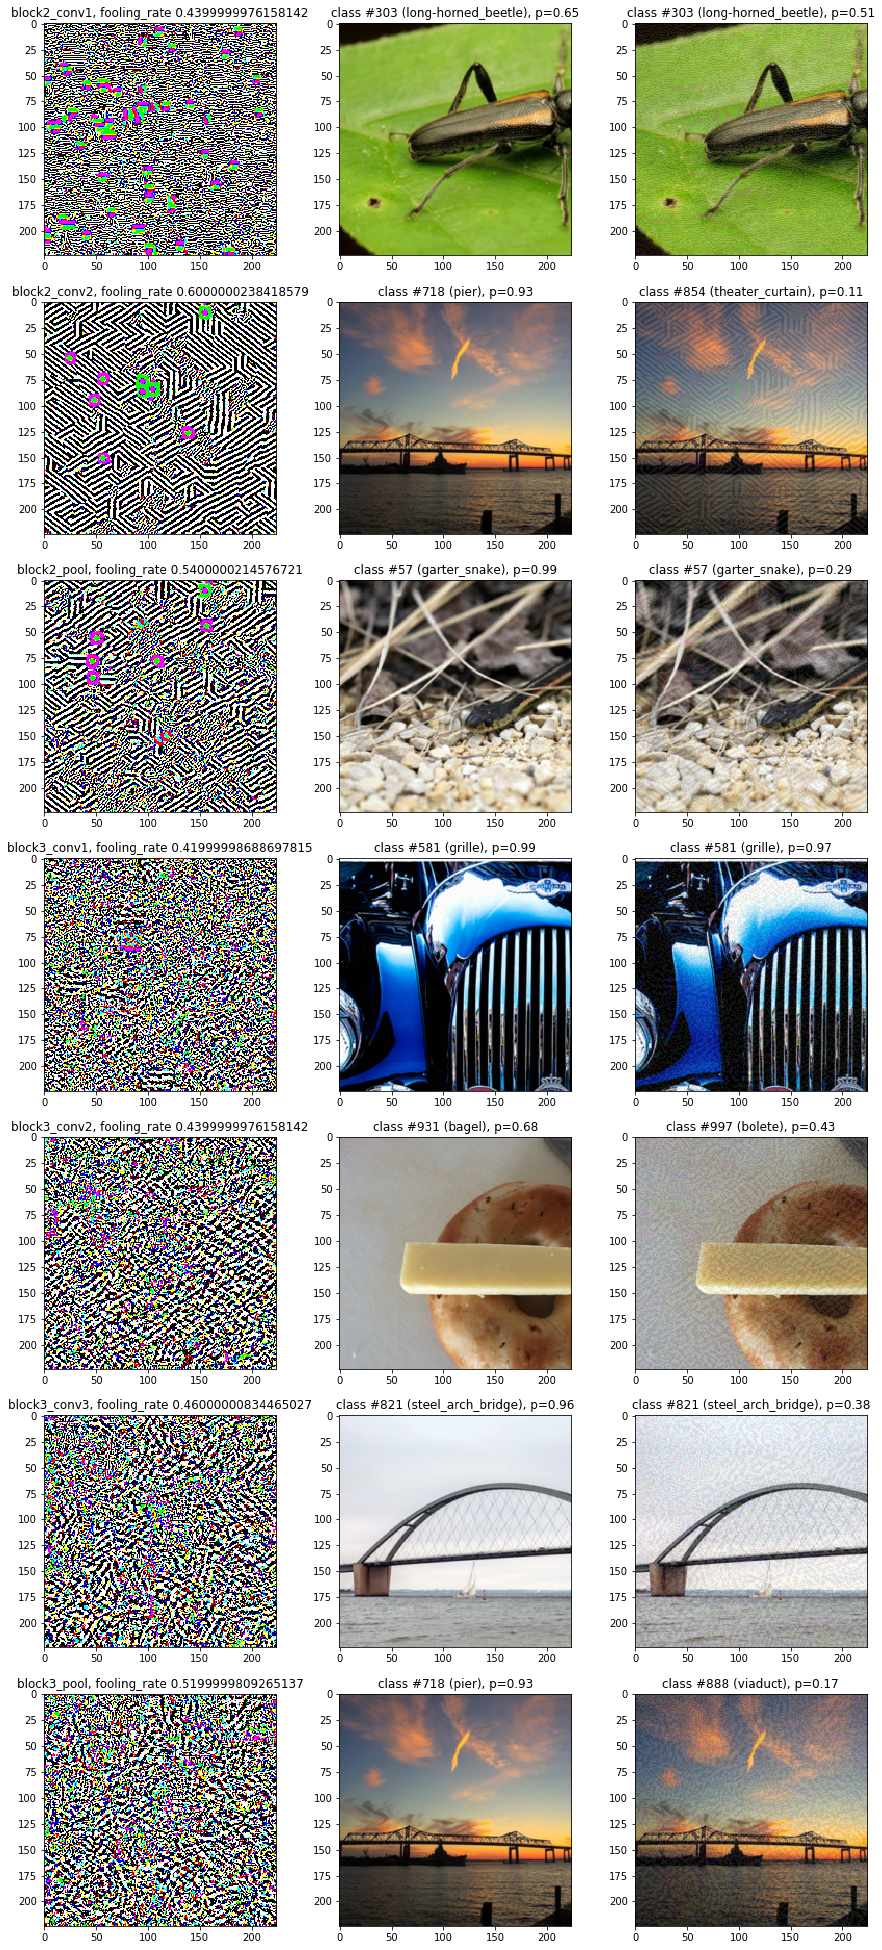

In [33]:
plot_examples('vgg16', img_batch)

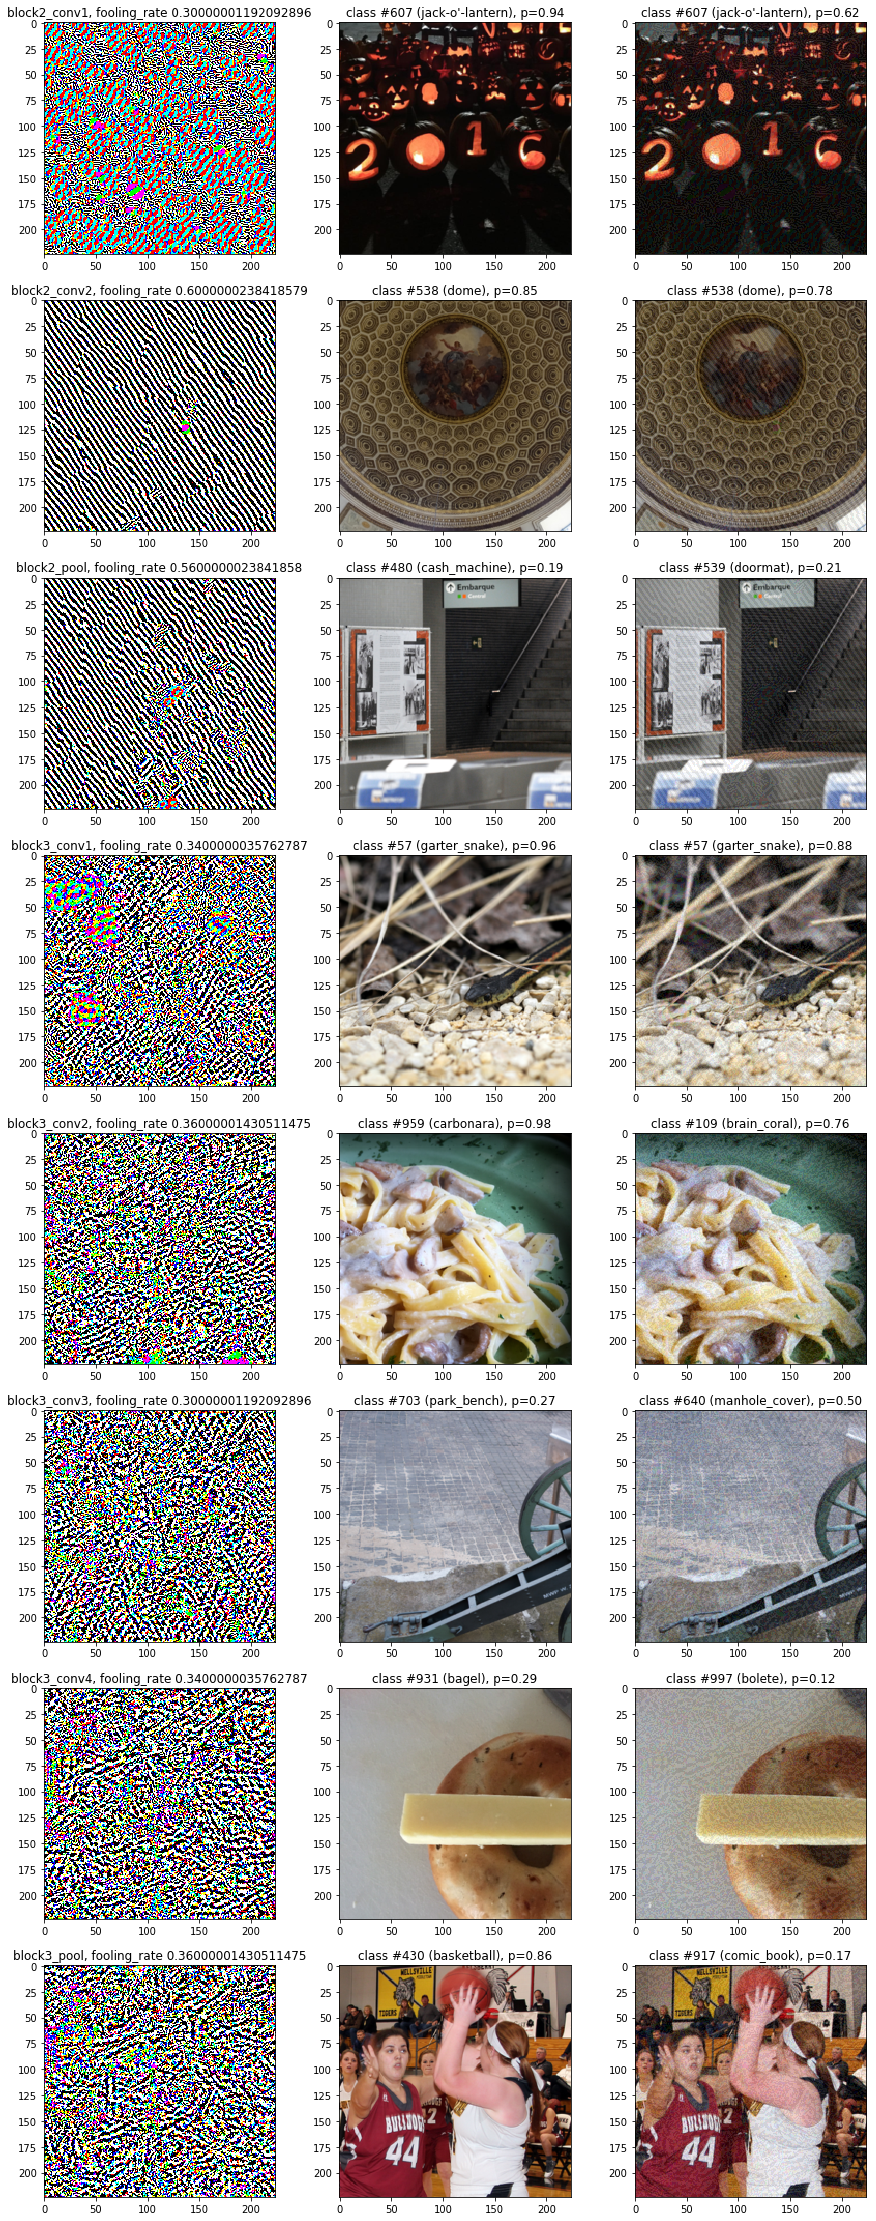

In [32]:
plot_examples('vgg19', img_batch)

In [13]:
model = models.vgg16(pretrained=True).to(device)
model.eval()

for layer in model.parameters():
    layer.requires_grad = False